# Intro to Stan

In [174]:
using Distributions
using StatsBase
using Plots
using StatsPlots
using StatisticalRethinking

# compiled and built Stan in dir that JULIA_CMDSTAN_HOME points to
using Stan
using StanSample
using StanOptimize

## Model Definition in Stan

Various Bayesian models can be explained in the Stan language. Here is an example.

Consider a globe tossing model (where $\theta$ is the proportion of water on the globe) such that:

$$ k \sim Binomial\ (N, \theta)$$

where

$$ \theta \sim Uniform\ (0,1) $$

In R, the a model could be defined as below

```
flist <- alist(
    theta ~ Uniform(0,1)
    k ~ Binomial(N, theta)
    )
```

Here we we will define the model in Stan, which uses 3 Stan language blocks:
1. data
    * An integer number of experiments (different to tosses n), or `int N` 
    * We know k (number of water tosses) cannot be negative, hence `int<lower=0> k[N]`, where `k[N]` is an int array
    * We know there has to be at least one throw (n is the number of tosses), hence `int<lower=1> n[N]`, where `n[N]` is an int array
2. parameters
    * $\theta$ is constrained as a real number between 0 and 1, hence `real<lower=0, upper=1> theta;
3. model
    * model and prior

Note that distribution names are lower case and that all statements in Stan end with a ;

In [6]:
model = "
// Inferring a rate
data {
    int N;
    int<lower=0> k[N];
    int<lower=1> n[N];
}
parameters {
    real <lower=0, upper=1> theta;
}
model {
    theta ~ uniform(0,1);
    k ~ binomial(n, theta);
}
";

## Model Computation

Now we can take the model definition and:

1. Create a Stanmodel object
2. Simulate the results of 15 repetitions (N experiments) of 9 tosses (n tosses) - this is the data
3. Input data
4. Sample posterior
5. Describe and check results

In [49]:
# create Stanmodel object
sm = StanSample.SampleModel("globe_model.1s", model);

# simulate results to produce data
N = 15 # 15 experiments
n = 9 # 9 globe tosses
data = Binomial(n, 0.66) # simulating Earth is 2/3 water

# prepare data for Stanmodel input
k_stan = rand(data, N) # we specified N experiments or N data points in the array k[N]
n_stan = repeat([n], N) # we specified N experiments in the array n[N]

globe_model_1_1_data = Dict("N" => N, "k" => k_stan, "n" => n_stan);

# sample data
rc = StanSample.stan_sample(sm, data=globe_model_1_1_data);


/tmp/tmpW5jIC7/globe_model.1s.stan updated.


## Stan Results - Summary Table and Plots

In [106]:
# show results and assign chains to DataFrames
if success(rc)
    chn = StanSample.read_samples(sm)
    chains_df = DataFrame(chn, append_chains=false)
    all_chains_df = DataFrame(chn)
    show(chn)
end

Object of type Chains, with data of type 1000×8×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__
parameters        = theta

2-element Array{ChainDataFrame,1}

Summary Statistics

│ Row │ parameters │ mean     │ std       │ naive_se    │ mcse       │ ess     │ r_hat   │
│     │ Symbol     │ Float64  │ Float64   │ Float64     │ Float64    │ Any     │ Any     │
├─────┼────────────┼──────────┼───────────┼─────────────┼────────────┼─────────┼─────────┤
│ 1   │ theta      │ 0.678023 │ 0.0394799 │ 0.000624232 │ 0.00096561 │ 1465.45 │ 1.00076 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%   │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64  │ Float64  │ Float64 │ Float64  │ Float64  │
├─────┼────────────┼──────────┼──────────┼─────────┼──────────┼──────────┤
│ 1   │ theta      │ 0.597966 │ 0.650614 │

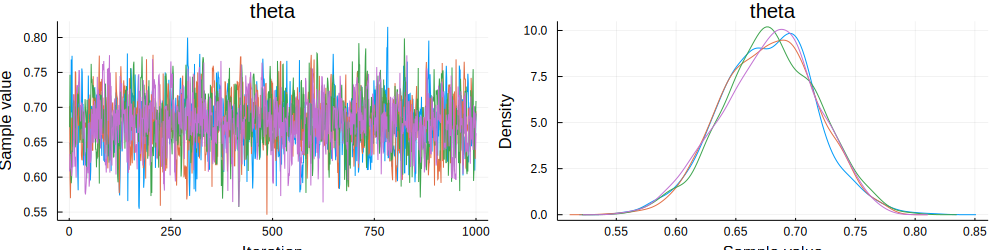

In [107]:
plot(chn)

## Quadratic Approximation - Fitting a Normal Distribution to the Posterior Samples

### Method 1 - Stan Optimize

In [111]:
sm_optimi = StanOptimize.OptimizeModel("globe_model.ls", model);
rc_optim = stan_optimize(sm_optimi, data=globe_model_1_1_data);


/tmp/tmp3mhbvv/globe_model.ls.stan updated.


In [120]:
if success(rc)
    optim_stan, cnames = read_optimize(sm_optimi)
    display(optim_stan)
end

Dict{Any,Any} with 3 entries:
  "theta"       => [0.681479, 0.681479, 0.68148, 0.681468]
  "lp__"        => [-84.4759, -84.4759, -84.4759, -84.4759]
  :stan_version => "2.19.1"

In [121]:
μ_stan_optimize = mean(optim_stan["theta"])
σ_stan_optimize = std(all_chains_df[:, :theta], mean=μ_stan_optimize)
println("Stan Optimize mean: $μ_stan_optimize \nStan Optimize std: $σ_stan_optimize")

Stan Optimize mean: 0.6814765 
Stan Optimize std: 0.039630707212508096


### Method 2 - Particle Approximation and Sample Data Calc

In [142]:
println("Calculated mean: $(mean(all_chains_df[:, :theta]))\nCalculated std: $(std(all_chains_df[:, :theta]))")

Calculated mean: 0.6780230637499999
Calculated std: 0.03947991577916129


In [153]:
p = Particles(all_chains_df[:, :theta])

Part4000(0.678 ± 0.0395)

### Method 3 - using QUAP in Rethinking Package

This just computes a KDE of the data, finds the point with max density (mean), calculates a stddev, then returns a normal distribution

In [151]:
d = quap(all_chains_df)
println("QUAP mean: $(mean(d[:theta]))\nQUAP std: $(std(d[:theta]))")

QUAP mean: 0.6850432167679671
QUAP std: 0.040097791039133295


### Method 4 - MLE (Bayesian inference with uniform prior for normal parameters)

In [170]:
mle = fit_mle(Normal, all_chains_df[:, :theta])

Normal{Float64}(μ=0.6780230637500018, σ=0.03947498048121349)

### Plot all methods

In [167]:
# 95% percentile interval using the chains
hpd(chn, alpha=0.05)

HPD

│ Row │ parameters │ upper    │ lower    │
│     │ Symbol     │ Float64  │ Float64  │
├─────┼────────────┼──────────┼──────────┤
│ 1   │ theta      │ 0.596686 │ 0.750924 │

In [175]:
# another way to find the 95% PI
quantile(all_chains_df[:, :theta], [0.025, 0.975])

2-element Array{Float64,1}:
 0.5979656250000001
 0.752678075       

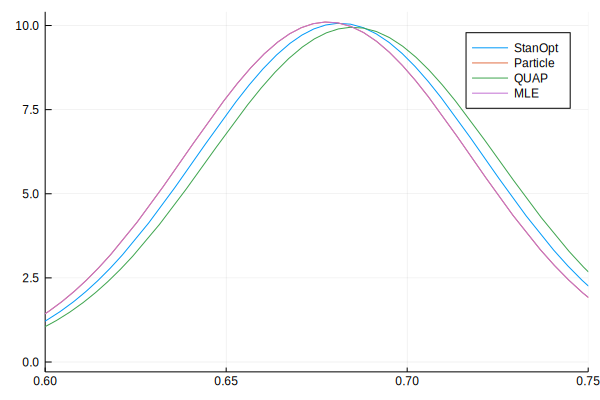

In [178]:
plot(Normal(μ_stan_optimize, σ_stan_optimize), xlims=(0.6, 0.75), label="StanOpt")
plot!(Normal(mean(p), std(p)), label="Particle")
plot!(Normal(mean(d[:theta]), std(d[:theta])), label="QUAP")
plot!(mle, label="MLE")